# For High Society, Low Recycling: the notebook
By [Sawyer Click](https://sawyerclick.github.io)



### Table of Contents
- [__Monthly Tonnage Reports__](#monthly-tonnage-reports)

#### About this project
This project looks at the recycling habits of New York City community districts over the last few decades. More specifically, I'm drilling in to Monthly Tonnage Reports and Census data to note how a district's demographics, such as poverty rate, median household income, and race, play into these habits.

#### Data notes
Monthly Tonnage Reports track residences and institutions (not businesses) serviced by New York's Department of Sanitation

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_colwidth', -1)

%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# <a id='monthly-tonnage-reports'>Reading in Monthly Tonnage Reports</a>

The data is compiled from [Monthly Tonnage Reports](https://data.cityofnewyork.us/City-Government/DSNY-Monthly-Tonnage-Data/ebb7-mvp5) from the Department of Sanitation.

Rows are by __month__ and __community-district__, which let's us build a timeline of recycling in New York City's districts

In [3]:
## here's what our data looks like
reports = pd.read_csv('monthly_tonnage_reports.csv')
reports.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID
0,1993 / 11,Manhattan,1,625.2,119.4,34.4,NaN,NaN,NaN,NaN,1
1,1995 / 09,Manhattan,1,633.1,117.2,45.8,NaN,NaN,NaN,NaN,1
2,1995 / 08,Manhattan,1,627.5,82.4,35.6,NaN,NaN,NaN,NaN,1
3,2012 / 03,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1
4,1992 / 03,Manhattan,1,726.0,NaN,NaN,NaN,NaN,NaN,NaN,1


## We need to run a bit of cleaning to help keep things organized

In [4]:
## let's fill NaNs with zeroes bc they mean 0 here
reports = reports.fillna(0)

## make datetime, separate the year
reports['datetime'] = pd.to_datetime(reports.MONTH)
reports['year'] = reports.datetime.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
reports['month'] = reports.datetime.astype(str).str.extract(r'^.*-(.*)-.*').astype(int)

## read back borough ids as strings
reports.BOROUGH_ID = reports.BOROUGH_ID.astype(str) 

# give the boro code by smashing together the borough id and community district number
def get_boro_code(x):
    return x.BOROUGH_ID + "{:02d}".format(x.COMMUNITYDISTRICT)
reports['borough_code'] = reports.apply(get_boro_code, axis=1)

## first we need to cut out 2020 months
## because the year isn't finished yet and we're most interested in years
reports = reports[(reports.year < 2020) & (reports.year > 2008)]

reports.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,datetime,year,month,borough_code
3,2012 / 03,Manhattan,1,1194.4,341.6,210.8,0.0,0.0,0.0,0.0,1,2012-03-01,2012,3,101
9,2012 / 01,Brooklyn,7,3156.7,436.6,343.4,0.0,0.0,0.0,20.1,3,2012-01-01,2012,1,307
13,2016 / 11,Brooklyn,7,3356.9,424.4,380.3,120.1,0.0,2.5,0.0,3,2016-11-01,2016,11,307
21,2013 / 11,Brooklyn,7,3179.2,398.7,318.3,57.5,0.0,0.0,0.0,3,2013-11-01,2013,11,307
23,2010 / 12,Brooklyn,7,2514.9,367.6,275.5,0.0,0.0,0.0,0.0,3,2010-12-01,2010,12,307


## Checking out refuse emissions from each borough

Remember! Some boroughs are more populous than others, cover a larger land mass, or have larger community districts. All of these mess with the raw numbers. This is mostly to give us an idea of what we're working with

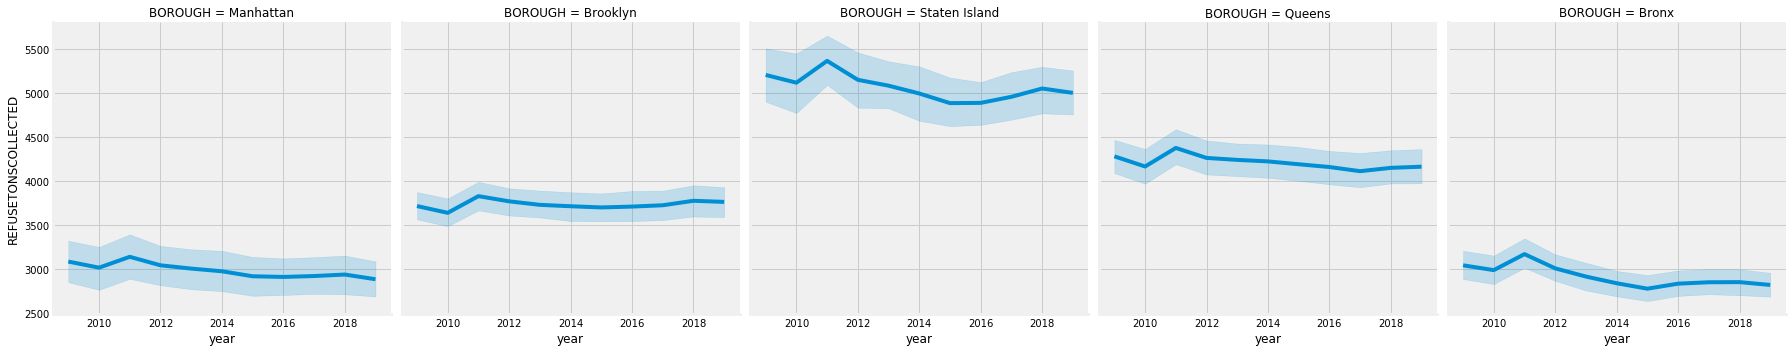

In [5]:
sns.relplot(data=reports,\
             x='year',\
             y='REFUSETONSCOLLECTED',\
             col='BOROUGH',\
             kind='line'\
            )

## Some cool math to get percentages!

In [6]:
reports.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,datetime,year,month,borough_code
3,2012 / 03,Manhattan,1,1194.4,341.6,210.8,0.0,0.0,0.0,0.0,1,2012-03-01,2012,3,101
9,2012 / 01,Brooklyn,7,3156.7,436.6,343.4,0.0,0.0,0.0,20.1,3,2012-01-01,2012,1,307
13,2016 / 11,Brooklyn,7,3356.9,424.4,380.3,120.1,0.0,2.5,0.0,3,2016-11-01,2016,11,307
21,2013 / 11,Brooklyn,7,3179.2,398.7,318.3,57.5,0.0,0.0,0.0,3,2013-11-01,2013,11,307
23,2010 / 12,Brooklyn,7,2514.9,367.6,275.5,0.0,0.0,0.0,0.0,3,2010-12-01,2010,12,307


In [7]:
## these are the basic recycled materials. 
## Paper, plastics + metals, and organics
reports['total_recycled'] = reports.PAPERTONSCOLLECTED\
                            + reports.MGPTONSCOLLECTED\
                            + reports.RESORGANICSTONS

## we can calculate total waste by adding these up
## refuse refers to non-recycled materials
reports['total_waste'] = reports.total_recycled\
                        + reports.REFUSETONSCOLLECTED

## now we can calculate percents to help put everyone on the same level!!
reports['percent_recycled'] = reports['total_recycled'] / reports['total_waste'] * 100

## Sorting totals by year to get diversion

In [8]:
racingChart = reports.groupby('year').total_recycled.sum().reset_index(name='Recycled')

racingChart['Waste'] = reports.groupby('year').REFUSETONSCOLLECTED.sum().reset_index(name='Waste').Waste
racingChart['Total'] = reports.groupby('year').total_waste.sum().reset_index(name='Total').Total

racingChart.to_csv('year_raw_waste_and_recycled.csv', index=False)
racingChart['Diversion'] = racingChart['Recycled'] / racingChart['Waste'] * 100
racingChart

,year,Recycled,Waste,Total,Diversion
0,2009,542333.4,2591531.2,3133864.6,20.927141
1,2010,520237.5,2534393.8,3054631.3,20.527098
2,2011,521395.4,2663828.9,3185224.3,19.573157
3,2012,494795.4,2586978.9,3081774.3,19.126379
4,2013,504466.2,2553356.8,3057823.0,19.756980
5,2014,528324.9,2528444.5,3056769.4,20.895254
6,2015,552411.1,2498990.8,3051401.9,22.105367
7,2016,585830.0,2503022.1,3088852.1,23.404907
8,2017,600721.5,2504617.2,3105338.7,23.984563
9,2018,628501.1,2528028.2,3156529.3,24.861317


In [9]:
## what's been the change in the amount of refuse?
## this tells us if there's been a change in waste and consumer habits
(racingChart['Waste'][10] - racingChart['Waste'][0]) / racingChart['Waste'][0] * 100

-3.0131298438543785

In [10]:
reports.groupby('year').total_recycled.sum() / reports.groupby('year').total_waste.sum() * 100

year
2009    17.305579
2010    17.031106
2011    16.369189
2012    16.055537
2013    16.497561
2014    17.283767
2015    18.103518
2016    18.965945
2017    19.344798
2018    19.911144
2019    20.079690
dtype: float64

## Sorting so we can make a ridgeplot

In [11]:
print(reports.groupby('BOROUGH').percent_recycled.median().sort_values())

def get_order(x):
    if x.BOROUGH == 'Bronx':
        return 1
    elif x.BOROUGH == 'Brooklyn':
        return 2
    elif x.BOROUGH == 'Queens':
        return 3
    elif x.BOROUGH == 'Staten Island':
        return 4
    elif x.BOROUGH == 'Manhattan':
        return 5
    
reports['mean_order'] = reports.apply(get_order, axis=1)

reports = reports.sort_values('mean_order')

BOROUGH
Bronx            12.584109
Brooklyn         15.587882
Queens           18.636092
Staten Island    20.144908
Manhattan        23.607803
Name: percent_recycled, dtype: float64


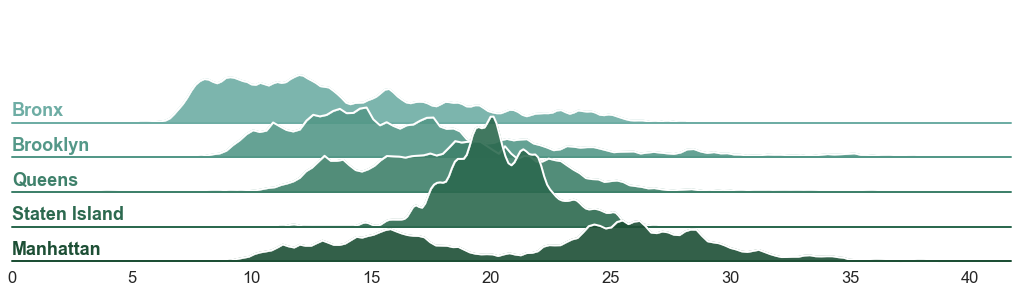

In [12]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale = 1.5)

# Initialize the FacetGrid object
pal = sns.color_palette("ch:2,r=.2,l=.6")
g = sns.FacetGrid(reports, row="BOROUGH", hue="BOROUGH", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "percent_recycled", clip_on=False, shade=True, alpha=.9, lw=1.5, bw=.2)
g.map(sns.kdeplot, "percent_recycled", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "percent_recycled")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.7)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_ylabels('')    
g.set_xlabels('')
g.set(yticks=[])
g.set(xticks=[0,5,10,15,20,25,30,35,40])
# g.set(xticklabe)
g.despine(bottom=True, left=True)

# plt.savefig('')

## percent difference calculator

In [13]:
## crude but a way to get unique borough codes matched
matchDF = reports[reports.year == 2019][['BOROUGH', 'borough_code', 'total_waste']].groupby(['BOROUGH','borough_code']).total_waste.sum().reset_index()

In [14]:
## 2019 community district recycling rates
bydist_2019 = (reports[reports['year'] == 2019].groupby('borough_code').total_recycled.sum()\
 / reports[reports['year'] == 2019].groupby('borough_code').total_waste.sum()\
 * 100).reset_index(name='pct_recyc_2019')

## 2009 community district recycling rates
bydist_2009 = (reports[reports['year'] == 2009].groupby('borough_code').total_recycled.sum()\
 / reports[reports['year'] == 2009].groupby('borough_code').total_waste.sum()\
 * 100).reset_index(name='pct_recyc_2009')

bydist = pd.merge(bydist_2019,bydist_2009, on='borough_code')
bydist.columns = ['borough_code','pct_recyc_2019','pct_recyc_2009']
bydist['pct_change'] = (bydist['pct_recyc_2019'] / bydist['pct_recyc_2009'] - 1) * 100

bydist['pct_point_change'] = bydist['pct_recyc_2019'] - bydist['pct_recyc_2009']

## adding comparitive raw data
## community district recycling, waste and refuse raw
bydist['raw_recyc2019'] = reports[reports['year'] == 2019].groupby('borough_code').total_recycled.sum().reset_index(name='total_recyc').total_recyc
bydist['raw_recyc2009'] = reports[reports['year'] == 2009].groupby('borough_code').total_recycled.sum().reset_index(name='total_recyc').total_recyc

bydist['raw_refuse2019'] = reports[reports['year'] == 2019].groupby('borough_code').REFUSETONSCOLLECTED.sum().reset_index(name='total_refuse').total_refuse
bydist['raw_refuse2009'] = reports[reports['year'] == 2009].groupby('borough_code').REFUSETONSCOLLECTED.sum().reset_index(name='total_refuse').total_refuse

## this is technically the ones above added together
bydist['raw_waste2019'] = reports[reports['year'] == 2019].groupby('borough_code').total_waste.sum().reset_index(name='total_waste').total_waste
bydist['raw_waste2009'] = reports[reports['year'] == 2009].groupby('borough_code').total_waste.sum().reset_index(name='total_waste').total_waste

## attach borough names
bydist = pd.merge(matchDF, bydist, on='borough_code')

## preview of our master set
bydist.head()

,BOROUGH,borough_code,total_waste,pct_recyc_2019,pct_recyc_2009,pct_change,pct_point_change,raw_recyc2019,raw_recyc2009,raw_refuse2019,raw_refuse2009,raw_waste2019,raw_waste2009
0,Bronx,201,26846.6,12.366184,7.870703,57.116635,4.495481,3319.9,1970.1,23526.7,23060.7,26846.6,25030.8
1,Bronx,202,21047.1,14.884711,8.893841,67.359754,5.990870,3132.8,1987.4,17914.3,20358.4,21047.1,22345.8
2,Bronx,203,26854.5,14.363328,7.740898,85.551197,6.622431,3857.2,1843.1,22997.3,21966.8,26854.5,23809.9
3,Bronx,204,55008.7,13.445328,7.735052,73.823361,5.710276,7396.1,4524.0,47612.6,53963.0,55008.7,58487.0
4,Bronx,205,47309.5,13.256323,10.276473,28.996815,2.979850,6271.5,5025.0,41038.0,43873.1,47309.5,48898.1


In [15]:
## is anyone producing more waste?
## this is what has killed zero waste in several cities

## new - old tells us who is recycling less. > 0 means there's more waste
moreWaste = bydist[bydist['raw_refuse2019'] - bydist['raw_refuse2009'] > 0]

print(f'There are {moreWaste.shape[0]} districts producing more waste out of the 59 total.')

moreWaste.BOROUGH.value_counts()

There are 20 districts producing more waste out of the 59 total.


Brooklyn     8
Queens       6
Manhattan    4
Bronx        2
Name: BOROUGH, dtype: int64

# Reading and cleaning demographic data

These are all from the census. I used social explorer

In [16]:
## there are a ton of columns so we're just going to use these
columns =[
    'borocd',
    'acres',
    'cd_full_title',
    'fp_100_rent_burden',
    'neighborhoods',
    'pct_bach_deg',
    'pct_foreign_born',
    'poverty_rate',
    'under18_rate'
]

demo_ish = pd.read_csv('demographic_data/cd_demographics.csv', usecols=columns)
demo_ish.borocd = demo_ish.borocd.astype(str)

demo_ish.head()

,acres,borocd,cd_full_title,fp_100_rent_burden,neighborhoods,pct_bach_deg,pct_foreign_born,poverty_rate,under18_rate
0,976.3,101,Manhattan Community District 1,0.353232,"Battery Park City, Civic Center, Ellis Island, Governors Island, Liberty Island, South Street Seaport, Tribeca, Wall Street, World Trade Center",82.3,23.9,8.8,12.8
1,865.9,102,Manhattan Community District 2,0.353232,"Greenwich Village, Hudson Square, Little Italy, NoHo, SoHo, South Village, West Village",82.3,23.9,8.8,12.8
2,1076.9,103,Manhattan Community District 3,0.463410,"Chinatown, East Village, Lower East Side, NoHo, Two Bridges",43.0,34.9,19.3,11.7
3,1131.6,104,Manhattan Community District 4,0.423210,"Chelsea, Clinton, Hudson Yards",74.4,29.4,11.3,8.2
4,1005.4,105,Manhattan Community District 5,0.000000,"Flatiron, Gramercy Park, Herald Square, Midtown, Midtown South, Murray Hill, Times Square, Union Square",74.4,29.4,11.3,8.2


In [17]:
## Fips here === community district
income = pd.read_csv('demographic_data/median_income.csv', skiprows=4, dtype={'Fips': str})

## stripping to most recent data | 2017
## and trimming it down to just the columns we need
income = income[(income.TimeFrame == 2017) & (income['Household Type'] == 'All Households')][['Data','Fips']].rename(columns={'Data':'income', 'Fips':'borocd'})

income.head()

,income,borocd
3120,144878.0,101
3121,144878.0,102
3122,39584.0,103
3123,101981.0,104
3124,101981.0,105


In [18]:
## Fips here === community district
population = pd.read_csv('demographic_data/total_population.csv', skiprows=4, dtype={'Fips': str})

## stripping to most recent data | 2017
## and trimming it down to just the columns we need
population = population[(population.TimeFrame == 2017) & (population['Fips'].str.contains(r'\w\w\w\w+') == False)][['Data','Fips', 'Location']].rename(columns={'Data':'population', 'Fips':'borocd'})

population.head()

,population,borocd,Location
780,60165.46615,101,Battery Park/Tribeca
781,88816.53385,102,Greenwich Village
782,160490.00000,103,Lower East Side
783,101603.53526,104,Chelsea/Clinton
784,50851.46474,105,Midtown Business District


In [19]:
income_and_pop = pd.merge(population, income, on='borocd')

In [20]:
## now we have a solid demographic dataset
demo = pd.merge(demo_ish, income_and_pop, on='borocd')
demo.head()

,acres,borocd,cd_full_title,fp_100_rent_burden,neighborhoods,pct_bach_deg,pct_foreign_born,poverty_rate,under18_rate,population,Location,income
0,976.3,101,Manhattan Community District 1,0.353232,"Battery Park City, Civic Center, Ellis Island, Governors Island, Liberty Island, South Street Seaport, Tribeca, Wall Street, World Trade Center",82.3,23.9,8.8,12.8,60165.46615,Battery Park/Tribeca,144878.0
1,865.9,102,Manhattan Community District 2,0.353232,"Greenwich Village, Hudson Square, Little Italy, NoHo, SoHo, South Village, West Village",82.3,23.9,8.8,12.8,88816.53385,Greenwich Village,144878.0
2,1076.9,103,Manhattan Community District 3,0.463410,"Chinatown, East Village, Lower East Side, NoHo, Two Bridges",43.0,34.9,19.3,11.7,160490.00000,Lower East Side,39584.0
3,1131.6,104,Manhattan Community District 4,0.423210,"Chelsea, Clinton, Hudson Yards",74.4,29.4,11.3,8.2,101603.53526,Chelsea/Clinton,101981.0
4,1005.4,105,Manhattan Community District 5,0.000000,"Flatiron, Gramercy Park, Herald Square, Midtown, Midtown South, Murray Hill, Times Square, Union Square",74.4,29.4,11.3,8.2,50851.46474,Midtown Business District,101981.0


# Merging recycling and demographic data

In [21]:
df = pd.merge(bydist, demo, left_on='borough_code',right_on='borocd')

df.head()

,BOROUGH,borough_code,total_waste,pct_recyc_2019,pct_recyc_2009,pct_change,pct_point_change,raw_recyc2019,raw_recyc2009,raw_refuse2019,...,cd_full_title,fp_100_rent_burden,neighborhoods,pct_bach_deg,pct_foreign_born,poverty_rate,under18_rate,population,Location,income
0,Bronx,201,26846.6,12.366184,7.870703,57.116635,4.495481,3319.9,1970.1,23526.7,...,Bronx Community District 1,0.580417,"Melrose, Mott Haven, Port Morris",10.3,29.5,31.0,28.4,99526.21296,Mott Haven,20966.0
1,Bronx,202,21047.1,14.884711,8.893841,67.359754,5.990870,3132.8,1987.4,17914.3,...,Bronx Community District 2,0.580417,"Hunts Point, Longwood",10.3,29.5,31.0,28.4,56830.78704,Hunts Point,20966.0
2,Bronx,203,26854.5,14.363328,7.740898,85.551197,6.622431,3857.2,1843.1,22997.3,...,Bronx Community District 3,0.530688,"Claremont, Crotona Park East, Melrose, Morrisania",13.3,31.4,30.3,28.9,92015.20058,Morrisania,25972.0
3,Bronx,204,55008.7,13.445328,7.735052,73.823361,5.710276,7396.1,4524.0,47612.6,...,Bronx Community District 4,0.617179,"Concourse, Concourse Village, East Concourse, Highbridge, Mount Eden, West Concourse",15.0,43.1,32.4,27.5,149710.00000,Concourse/Highbridge,30900.0
4,Bronx,205,47309.5,13.256323,10.276473,28.996815,2.979850,6271.5,5025.0,41038.0,...,Bronx Community District 5,0.650425,"Fordham, Morris Heights, Mount Hope, University Heights",13.1,43.4,35.6,28.7,148339.00000,University Heights,30166.0


In [22]:
## sorting from greatest change to least and given them places
df = df.sort_values('pct_point_change', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index':'place'})

In [23]:
## send to a csv
df.to_csv('data.csv', index=False)

## take this to QGIS for a spatial join with community-districts.geojson
## export as data.geojson
## use mapshaper to make it data.json as topojson

# Analysis

In [24]:
## What's the city's median income?
median_income = df.income.median()

## Income histogram by community district

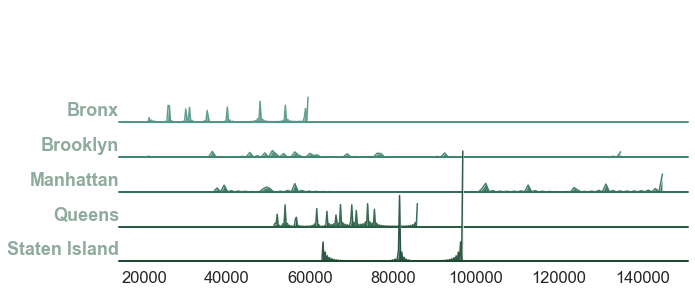

In [25]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale = 1.5)

# Initialize the FacetGrid object
pal = sns.color_palette("ch:2,r=.2,l=.5")
g = sns.FacetGrid(df, row="BOROUGH", hue="BOROUGH", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "income", clip_on=False, shade=True, alpha=.9, lw=1.5, bw=.2)
# g.map(sns.kdeplot, "income", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color='#44745C',
            ha="right", va="center", transform=ax.transAxes, alpha=.6)
    
g.map(label, "income")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.7)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_ylabels('')    
g.set_xlabels('')
g.set(yticks=[])
# g.set(xticks=[0,5,10,15,20,25,30,35,40])
# g.set(xticklabe)
g.despine(bottom=True, left=True)

# plt.savefig('')

### How rich are those recycling less?

FINDINGS:
- All five of the districts that are recycling a lower percentage of their waste have an income incredibly above the city's median of about $57k

In [26]:
df[df.pct_point_change < 0][['BOROUGH','borough_code','income']]

,BOROUGH,borough_code,income
54,Staten Island,502,81487.0
55,Brooklyn,318,76647.0
56,Staten Island,503,96796.0
57,Manhattan,101,144878.0
58,Manhattan,106,112383.0


Poorer districts made more significant gains


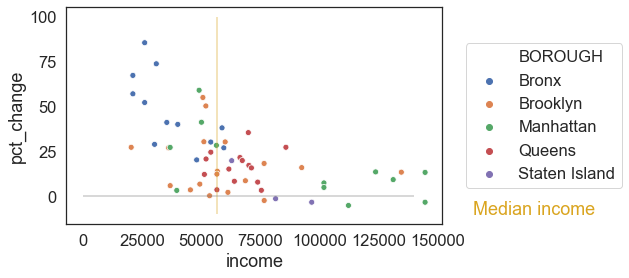

In [27]:
## this shows the percentage change, not percentage point change
## the idea is I want to see how significant of a shift the change was, not necessarily the raw change
g = sns.scatterplot(data=df, x='income', y='pct_change', hue='BOROUGH')
g.legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, facecolor='w')
g.vlines(median_income, -10, 100, color='goldenrod', alpha=.4)
g.hlines(0,0,140000, color='gray', alpha=.4)
plt.text(165000,-10,'Median income', color='goldenrod')
print('Poorer districts made more significant gains')

Poorer districts made more significant gains


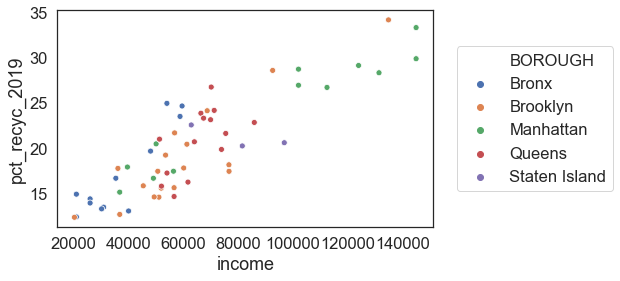

In [46]:
## this shows the percentage change, not percentage point change
## the idea is I want to see how significant of a shift the change was, not necessarily the raw change
g = sns.scatterplot(data=df, x='income', y='pct_recyc_2019', hue='BOROUGH')
g.legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, facecolor='w')
# g.vlines(median_income, -10, 100, color='goldenrod', alpha=.4)
# g.hlines(0,0,140000, color='gray', alpha=.4)
# plt.text(165000,-10,'Median income', color='goldenrod')
print('Poorer districts made more significant gains')

In [28]:
## The average person in the city is resposible for 
# 364,725 pounds of waste sent to a landfill, incinerator or the ocean
(df.raw_waste2019.sum() * 1000000) / df.population.sum()

364725.16237252933

In [47]:
df[((df.raw_refuse2009 - df.raw_refuse2019) < 0) & (df.income > median_income)][['BOROUGH','borough_code','raw_refuse2019', 'raw_refuse2009', 'income', 'pct_point_change']]

,BOROUGH,borough_code,raw_refuse2019,raw_refuse2009,income,pct_point_change
18,Brooklyn,302,29941.8,25913.4,92562.0,3.955169
20,Queens,402,35340.1,32472.7,67359.0,3.883460
33,Brooklyn,301,64018.7,53459.1,76608.0,2.814174
39,Queens,412,81078.8,79745.1,61670.0,2.146558
43,Queens,408,43169.5,42020.8,64005.0,1.612985
44,Queens,410,44977.0,44462.9,73891.0,1.467025
45,Manhattan,104,28331.4,25160.8,101981.0,1.375338
52,Brooklyn,315,53355.0,52977.6,61274.0,0.456551
55,Brooklyn,318,65818.4,64147.4,76647.0,-0.402186
57,Manhattan,101,16545.7,13451.8,144878.0,-1.109078


In [48]:
df[df.income < median_income][['BOROUGH','borough_code','pct_point_change', 'place']].shape[0]

29

In [61]:
df.sort_values('pct_point_change')[['BOROUGH','borough_code','pct_point_change', 'raw_waste2019','raw_waste2009', 'raw_recyc2019','raw_recyc2009']].head()

,BOROUGH,borough_code,pct_point_change,raw_waste2019,raw_waste2009,raw_recyc2019,raw_recyc2009
58,Manhattan,106,-1.407075,46916.1,50593.9,12533.4,14227.8
57,Manhattan,101,-1.109078,24823.0,20522.8,8277.3,7071.0
56,Staten Island,503,-0.682895,86217.5,88949.5,17750.6,18920.5
55,Brooklyn,318,-0.402186,79701.1,78057.8,13882.7,13910.4
54,Staten Island,502,-0.259969,63637.0,65646.0,12874.4,13451.5


In [55]:
df.sort_values('income', ascending=False)[['BOROUGH','borough_code','income','pct_point_change']].head(10)

,BOROUGH,borough_code,income,pct_point_change
25,Manhattan,102,144878.0,3.529911
57,Manhattan,101,144878.0,-1.109078
17,Brooklyn,306,134804.0,4.069437
37,Manhattan,108,131348.0,2.426845
26,Manhattan,107,123894.0,3.501982
58,Manhattan,106,112383.0,-1.407075
45,Manhattan,104,101981.0,1.375338
41,Manhattan,105,101981.0,1.888399
56,Staten Island,503,96796.0,-0.682895
18,Brooklyn,302,92562.0,3.955169


In [52]:
df[df.pct_point_change < 0][['place','BOROUGH','borough_code','income','neighborhoods']]

,place,BOROUGH,borough_code,income,neighborhoods
54,54,Staten Island,502,81487.0,"Arrochar, Bloomfield, Bulls Head, Chelsea, Concord, Dongan Hills, Egbertville, Emerson Hill, Grant City, Grasmere, Heartland Village, Lighthouse Hill, Manor Heights, Midland Beach, New Dorp, New Dorp Beach, New Springville, Old Town, South Beach, Todt Hill, Travis, Willowbrook"
55,55,Brooklyn,318,76647.0,"Bergen Beach, Canarsie, Flatlands, Georgetown, Marine Park, Mill Basin, Mill Island, Paerdegat Basin"
56,56,Staten Island,503,96796.0,"Annadale, Arden Heights, Bay Terrace, Butler Manor, Charleston, Eltingville, Fresh Kills, Great Kills, Greenridge, Huguenot, Oakwood, Oakwood Beach, Oakwood Heights, Pleasant Plains, Prince's Bay, Richmond Town, Richmond Valley, Rossville, Sandy Ground, Tottenville, Woodrow"
57,57,Manhattan,101,144878.0,"Battery Park City, Civic Center, Ellis Island, Governors Island, Liberty Island, South Street Seaport, Tribeca, Wall Street, World Trade Center"
58,58,Manhattan,106,112383.0,"Beekman Place, Gramercy Park, Murray Hill, Peter Cooper Village, Stuyvesant Town, Sutton Place, Tudor City, Turtle Bay"


## Monthly tonnage from NYC Open Data
- data is by community district
- dates back consistently to 2004-ish, but we're focusing on the last decade
- not using 2019 because the year isn't over!

In [64]:
df = pd.read_csv('src/data/monthly_tonnage.csv', na_values='NaN')
df = df.fillna(0)
## make datetime, separate the year
df.MONTH = pd.to_datetime(df.MONTH)
df['year'] = df.MONTH.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
df.BOROUGH_ID = df.BOROUGH_ID.astype(str)

df = df[df.year > 2008] ## just for the past 10 years

## some math to get the percents and totals
df['total_recycled'] = df.PAPERTONSCOLLECTED + df.MGPTONSCOLLECTED + df.RESORGANICSTONS
df['total_waste'] = df.total_recycled + df.REFUSETONSCOLLECTED
df['percent_recycled'] = df['total_recycled'] / df['total_waste'] * 100

# give the borough code
def get_boro_code(x):
    return x.BOROUGH_ID + "{:02d}".format(x.COMMUNITYDISTRICT)
df['borough_code'] = df.apply(get_boro_code, axis=1)

bydist_2018 = df[df['year']==2018].groupby('borough_code').percent_recycled.mean().reset_index()
bydist_2009 = df[df['year']==2009].groupby('borough_code').percent_recycled.mean().reset_index()

bydist = pd.merge(bydist_2018,bydist_2009['percent_recycled'],left_index=True,right_index=True)
bydist.columns = ['borough_code','pct_recyc_2018','pct_recyc_2009']
bydist['pct_change'] = (bydist['pct_recyc_2018'] / bydist['pct_recyc_2009'] - 1) * 100



bydist['pct_point_change'] = bydist['pct_recyc_2018'] - bydist['pct_recyc_2009']

demo_df = pd.read_csv('src/data/Bronx-2-indicators.csv')
demo_df.borocd = demo_df.borocd.astype(str)

merged = bydist.merge(demo_df, left_on='borough_code', right_on='borocd')
merged.to_csv('src/data/demographics_and_recyc.csv', index=False)

In [69]:
merged.sort_values('pct_change')

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change,the_geom,lots_parking,the_geom_webmercator,acres,acs_tooltip,...,son_issue_1,son_issue_2,son_issue_3,total_lot_area,under18_rate,under18_rate_boro,under18_rate_nyc,unemployment_boro,unemployment_cd,unemployment_nyc
0,101,31.822169,34.408124,-7.515536,-2.585955,NaN,23,NaN,976.3,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3810, which is an approximation of both Manhattan CD 1 and Manhattan CD 2",...,Resiliency,Traffic,Other,36115322,12.8,14.5,21,4.2,2.8,4.9
5,106,25.965936,28.033464,-7.375213,-2.067528,NaN,22,NaN,888.5,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3808, which is an approximation of Manhattan CD 6",...,Affordable housing,Parks,Senior services,25705923,8.7,14.5,21,4.2,2.4,4.9
58,503,20.663840,21.422623,-3.541969,-0.758783,NaN,165,NaN,13750.9,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3901, which is an approximation of Staten Island CD 3",...,Street conditions (roadway maintenance),Street flooding,Traffic,476202613,21.5,22.1,21,3.2,3.2,4.9
41,318,17.455396,17.918633,-2.585229,-0.463238,NaN,197,NaN,5410.5,"American Community Survey 2013-2017 5-Year Estimates for PUMA 4009, which is an approximation of Brooklyn CD 18",...,Parks,Resiliency,Street conditions (roadway maintenance),203459457,22.9,23.1,21,5.1,4.9,4.9
57,502,20.412181,20.646595,-1.135363,-0.234414,NaN,160,NaN,13617.2,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3902, which is an approximation of Staten Island CD 2",...,Senior services,Traffic,Other,457047905,21.1,22.1,21,3.2,3.2,4.9
3,104,27.510916,27.317897,0.706566,0.193019,NaN,77,NaN,1131.6,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3807, which is an approximation of both Manhattan CD 4 and Manhattan CD 5",...,Affordable housing,Neighborhood preservation (development trends),Traffic,38177268,8.2,14.5,21,4.2,3.7,4.9
4,105,25.725851,25.016822,2.834209,0.709029,NaN,39,NaN,1005.4,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3807, which is an approximation of both Manhattan CD 5 and Manhattan CD 4",...,Affordable housing,Social services (including services for the homeless),Transit (buses & subways),28192622,8.2,14.5,21,4.2,3.7,4.9
34,311,19.741199,19.154240,3.064380,0.586959,NaN,95,NaN,2368.6,"American Community Survey 2013-2017 5-Year Estimates for PUMA 4017, which is an approximation of Brooklyn CD 11",...,"Quality of life issues (noise, graffiti, petty crime, etc.)",Street conditions (roadway maintenance),Trash removal & cleanliness,69469761,20.9,23.1,21,5.1,4.4,4.9
28,305,12.411104,11.959023,3.780254,0.452081,NaN,546,NaN,3569.3,"American Community Survey 2013-2017 5-Year Estimates for PUMA 4008, which is an approximation of Brooklyn CD 5",...,Affordable housing,Cultural facilities & programs,Unemployment,113654190,25.9,23.1,21,5.1,5.1,4.9
2,103,18.031489,17.288615,4.296899,0.742874,NaN,57,NaN,1076.9,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3809, which is an approximation of Manhattan CD 3",...,Affordable housing,Senior services,Other,33692052,11.7,14.5,21,4.2,4.1,4.9


In [15]:
demo_df[['borocd', 'fp_100_mhhi']].sort_values('fp_100_mhhi', ascending=False)

,borocd,fp_100_mhhi
0,101,121000.0
1,102,121000.0
25,302,119000.0
3,104,105000.0
43,402,101000.0
24,301,93000.0
5,106,92000.0
6,107,87000.0
7,108,72000.0
33,310,56000.0


In [17]:
bydist.sort_values('pct_point_change', ascending=
True)

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
0,101,46.762885,52.548161,-0.110095,-5.785276
5,106,35.122010,39.073204,-0.101123,-3.951195
58,503,26.075177,27.377909,-0.047583,-1.302732
41,318,21.171278,21.877450,-0.032279,-0.706172
57,502,25.675147,26.126501,-0.017276,-0.451354
3,104,38.006061,37.666509,0.009015,0.339552
28,305,14.176288,13.591706,0.043010,0.584582
34,311,24.611005,23.725281,0.037332,0.885724
44,403,17.365207,16.467526,0.054512,0.897682
35,312,19.018832,18.020678,0.055389,0.998154


In [87]:
bydist[bydist.borough_code.str.contains(r'5..') == True]

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
56,501,0.288775,0.235038,22.863147,0.053737
57,502,0.256751,0.261265,-1.727573,-0.004514
58,503,0.260752,0.273779,-4.758331,-0.013027


In [6]:
print('total refuse collected')
print(df[df.year == 2009].REFUSETONSCOLLECTED.sum())
print(df[df.year == 2018].REFUSETONSCOLLECTED.sum())
print('\n')

print('total recycle collected')
print(df[df.year == 2009].total_recycled.sum())
print(df[df.year == 2018].total_recycled.sum())

total refuse collected
2591531.2
2528028.2


total recycle collected
542333.3999999999
593412.0


In [7]:
df.keys()

Index(['MONTH', 'BOROUGH', 'COMMUNITYDISTRICT', 'REFUSETONSCOLLECTED',
       'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED', 'RESORGANICSTONS',
       'SCHOOLORGANICTONS', 'LEAVESORGANICTONS', 'XMASTREETONS', 'BOROUGH_ID',
       'year', 'total_recycled', 'percent_recycled', 'borough_code'],
      dtype='object')

In [8]:
print('The 2009 waste outputs were')
print(df[df.year == 2009].groupby('BOROUGH').REFUSETONSCOLLECTED.sum())

print('\n')

print('The 2018 waste outputs were')
print(df[df.year == 2018].groupby('BOROUGH').REFUSETONSCOLLECTED.sum())


The 2009 waste outputs were
BOROUGH
Bronx            437885.5
Brooklyn         802636.9
Manhattan        444044.4
Queens           719429.3
Staten Island    187535.1
Name: REFUSETONSCOLLECTED, dtype: float64


The 2018 waste outputs were
BOROUGH
Bronx            410308.5
Brooklyn         815628.8
Manhattan        422740.9
Queens           697380.6
Staten Island    181969.4
Name: REFUSETONSCOLLECTED, dtype: float64


In [9]:
print('The 2009 recycling outputs were')
print(df[df.year == 2009].groupby('BOROUGH').total_recycled.sum())

print('\n')

print('The 2018 recycling outputs were')
print(df[df.year == 2018].groupby('BOROUGH').total_recycled.sum())


The 2009 recycling outputs were
BOROUGH
Bronx            61685.4 
Brooklyn         156004.1
Manhattan        122488.4
Queens           154652.8
Staten Island    47502.7 
Name: total_recycled, dtype: float64


The 2018 recycling outputs were
BOROUGH
Bronx            76625.1 
Brooklyn         174584.6
Manhattan        129404.5
Queens           166399.4
Staten Island    46398.4 
Name: total_recycled, dtype: float64


In [10]:
## a preview of our data
df.head(3)

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,year,total_recycled,percent_recycled,borough_code
3,2012-03-01,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1,2012,552.4,0.462492,101
9,2012-01-01,Brooklyn,7,3156.7,436.6,343.4,NaN,NaN,NaN,20.1,3,2012,780.0,0.247093,307
13,2016-11-01,Brooklyn,7,3356.9,424.4,380.3,120.1,NaN,2.5,NaN,3,2016,804.7,0.239715,307


## The hierarchy of boroughs that recycle the most of their waste hasn't changed

In [11]:
recycled_2018_df = df[df.year == 2018].groupby('BOROUGH').percent_recycled.mean().reset_index()
recycled_2009_df = df[df.year == 2009].groupby('BOROUGH').percent_recycled.mean().reset_index()

print('Boroughs that recycled the highest percentage of their waste from 2018')
print(recycled_2018_df.sort_values('percent_recycled', ascending=False))
print('\n')
print('Boroughs that recycled the highest percentage of their waste from 2009')
print(recycled_2009_df.sort_values('percent_recycled', ascending=False))

Boroughs that recycled the highest percentage of their waste from 2018
         BOROUGH  percent_recycled
2  Manhattan      0.310225        
4  Staten Island  0.256344        
3  Queens         0.244487        
1  Brooklyn       0.224451        
0  Bronx          0.187468        


Boroughs that recycled the highest percentage of their waste from 2009
         BOROUGH  percent_recycled
2  Manhattan      0.288883        
4  Staten Island  0.256694        
3  Queens         0.220350        
1  Brooklyn       0.200168        
0  Bronx          0.140134        


### Some math to calculate changes over time

In [12]:
bydist_2018 = df[df['year']==2018].groupby('borough_code').percent_recycled.mean().reset_index()
bydist_2009 = df[df['year']==2009].groupby('borough_code').percent_recycled.mean().reset_index()

bydist = pd.merge(bydist_2018,bydist_2009['percent_recycled'],left_index=True,right_index=True)
bydist.columns = ['borough_code','pct_recyc_2018','pct_recyc_2009']
bydist['pct_change'] = bydist['pct_recyc_2018'] / bydist['pct_recyc_2009'] - 1
bydist['pct_point_change'] = bydist['pct_recyc_2018'] - bydist['pct_recyc_2009']
bydist.to_csv('10-year-change.csv', index=False)

## But when checking out changes over the decades by individual districts, the Bronx leads the way

In [13]:
print('The community districts with the greatest percentage point increases are mostly in the Bronx (2**)')
bydist.sort_values('pct_change', ascending=False).head()

The community districts with the greatest percentage point increases are mostly in the Bronx (2**)


,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
14,203,0.150308,0.083908,0.791348,0.066400
13,202,0.165163,0.097582,0.692550,0.067580
15,204,0.138580,0.083743,0.654833,0.054837
9,110,0.186162,0.116931,0.592069,0.069231
27,304,0.201336,0.126831,0.587433,0.074505


In [14]:
print('The community districts with the lowest percentage point decreases are mostly in Mahattan (1**), Brooklyn (3**) and Staten Island (5**)')
bydist.sort_values('pct_change', ascending=True).head()

The community districts with the lowest percentage point decreases are mostly in Mahattan (1**), Brooklyn (3**) and Staten Island (5**)


,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
0,101,0.457068,0.525482,-0.130192,-0.068414
5,106,0.341653,0.390732,-0.125609,-0.049079
58,503,0.260752,0.273779,-0.047583,-0.013027
34,311,0.228816,0.237253,-0.035561,-0.008437
41,318,0.211713,0.218775,-0.032279,-0.007062


In [15]:
# opening the community-districts json from NYC Open Data
with open('src/data/community-districts.json') as f:
    data = json.load(f)

### One Dataset to Rule Them All 

It has demographic data from NYC Open Data (originally pulled from the Census), the Monthly Tonnage Data, and the math we did to calculate change over time

### The districts with the highest poverty rate have among the highest percentage increase in recycling in the last decade

The Bronx takes up 6 of the 10 districts with the greatest increase, with each of the 6 districts having a higher poverty rate than the others

In [53]:
df = pd.read_csv('src/data/joined_and_tonnage.csv')
df = df[df.year == 2018].groupby('boro_cd')
poverty_df = df['pct_change'].median().reset_index().merge(df['poverty_rate'].median().reset_index(), on='boro_cd')
poverty_df = poverty_df.merge(df.fp_100_mhhi.median().reset_index(), on='boro_cd').rename(columns={'fp_100_mhhi':'median_household_income'})
poverty_df = poverty_df.merge(df.pct_recyc_2018.mean().reset_index(), on='boro_cd')
poverty_df = poverty_df.merge(df.pct_recyc_2009.mean().reset_index()  , on='boro_cd')
poverty_df['pct_pt_change'] = (poverty_df.pct_recyc_2018 - poverty_df.pct_recyc_2009) * 100
poverty_df['pct_change'] = poverty_df['pct_change'] * 100

In [38]:
pos = poverty_df[(poverty_df.pct_pt_change > 0)].sort_values('pct_pt_change', ascending=True)

print('The median poverty rate of the top 50 districts with a positive
 recycling percentage point increase is ' + pos.sort_values('pct_pt_change', ascending=False).poverty_rate.median().astype(str) + '% and the median household income is $'+pos.sort_values('pct_pt_change', ascending=False).median_household_income.median().astype(str))

# poverty_df[['boro_cd', 'poverty_rate', 'pct_pt_change', 'pct_change', 'median_household_income']].sort_values('pct_pt_change', ascending=False).head(10)


pos[['boro_cd', 'poverty_rate', 'median_household_income', 'pct_pt_change']].sort_values('pct_pt_change', ascending=False)


The median poverty rate of the top 10 districts with the greatest recycling percentage point increase is 20.65% and the median household income is $32000.0


,boro_cd,poverty_rate,median_household_income,pct_pt_change
27,304,24.8,NaN,7.450488
9,110,20.2,25000.0,6.923126
8,109,20.7,32000.0,6.871353
13,202,31.0,17000.0,6.758049
14,203,30.3,31000.0,6.640009
42,401,18.1,51000.0,6.405746
26,303,21.2,NaN,5.807153
18,207,27.4,NaN,5.584546
19,208,15.8,47000.0,5.540257
15,204,32.4,24000.0,5.483737


### Districts with the greatest decrease have a lower poverty rate

In [36]:
neg = poverty_df[(poverty_df.pct_pt_change < 0)].sort_values('pct_pt_change', ascending=True)

print('The median poverty rate of the 9 districts with a negative recycling percentage point decrease is ' + neg.poverty_rate.median().astype(str) + '% and the median household income is $'+neg.median_household_income.median().astype(str))

print("\nOnly these 9 districts had a decrease in their recycling")

neg[['boro_cd', 'poverty_rate', 'median_household_income', 'pct_pt_change']] 


The median poverty rate of the 9 districts with a negative recycling percentage point decrease is 14.6% and the median household income is $41500.0

Only these 9 districts had a decrease in their recycling


,boro_cd,poverty_rate,median_household_income,pct_pt_change
0,101,8.8,121000.0,-6.841355
5,106,9.8,92000.0,-4.907941
58,503,12.3,44000.0,-1.302732
34,311,22.5,35000.0,-0.843702
41,318,14.6,36000.0,-0.706172
3,104,11.3,105000.0,-0.461614
57,502,14.9,37000.0,-0.454724
38,315,18.6,39000.0,-0.410527
35,312,27.2,NaN,-0.033087


In [40]:
print("Districts with a poverty rate above 25 percent have an average increase of " + (poverty_df[poverty_df.poverty_rate > 25]['pct_pt_change'].median()).astype(str) + '%')

print("\nDistricts with a poverty rate below 10 percent have an average increase of " + (poverty_df[poverty_df.poverty_rate < 15]['pct_pt_change'].median()).astype(str) + '%')

Districts with a poverty rate above 25 percent have an average increase of 3.7116161000000005%

Districts with a poverty rate below 10 percent have an average increase of 2.630041300000005%


In [28]:
model = smf.ols(formula='pct_change ~ median_household_income', data=poverty_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     8.131
Date:                Thu, 05 Dec 2019   Prob (F-statistic):            0.00678
Time:                        20:22:29   Log-Likelihood:                -189.22
No. Observations:                  43   AIC:                             382.4
Df Residuals:                      41   BIC:                             386.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  31.9103      5.660      5.638      0.000      20.480      43.341
median_household_income    -0.0003      0.000     -2.852      0.007      -0.000   -8.39e-05
==============================================================================
Omnibus:                        6.637   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                5.863
Skew:                           0.896   Prob(JB):                       0.0533
Kurtosis:                       3.251   Cond. No.                     1.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
joined = pd.read_csv('src/data/joined_and_tonnage.csv')
joined['point_change'] = joined['pct_recyc_2018'] - joined['pct_recyc_2009']

In [0]:
# What effect does the number of coffees sold have on our revenue?
model = smf.ols(formula='REFUSETONSCOLLECTED ~ fp_100_mhhi', data=joined)
results = model.fit()

results.summary()

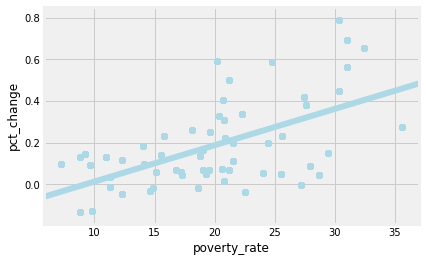

In [67]:
%matplotlib inline

import seaborn as sns

sns.regplot(x='poverty_rate', y='pct_change', ci=None, data=joined, color='lightblue')

<hr>

## 311 data regarding missed recyling collections

Data is <code>311_Service_Requests_from_2010_to_Present.csv</code>

I grabbed and filtered the data on NYC Open Data and filtered it to only include DSNY complaints mentioning recycling

In [180]:
df_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', usecols=['Unique Key', 'Created Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor','Location Type', 'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Resolution Description', 'Community Board', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude', 'Borough'])
df_311['year'] = df_311['Created Date'].str.extract('\d+\/\d+\/(\d+)') ## this grabs the year

In [181]:
df_311.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,City,Resolution Description,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Latitude,Longitude,year
0,44916024,11/13/2019 10:19:00 AM,DSNY,BCC - Queens West,Missed Collection (All Materials),1R Missed Recycling-All Materials,Sidewalk,11378.0,59-15 69 LANE,69 LANE,Maspeth,The Department of Sanitation is in the process...,05 QUEENS,QUEENS,1014336.0,203004.0,40.723825,-73.891457,2019


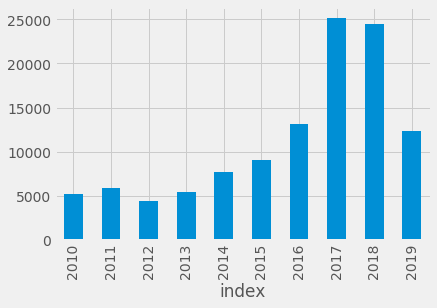

In [182]:
df_311.year.value_counts().reset_index().sort_values('index', ascending=True).plot(kind='bar', x='index', y='year', legend=False)

In [183]:
df_311['Community Board'].value_counts().head(10)

01 STATEN ISLAND    14443
03 STATEN ISLAND    13643
02 STATEN ISLAND     9859
01 BROOKLYN          5280
07 QUEENS            4791
12 BROOKLYN          3307
13 QUEENS            3241
03 BROOKLYN          2706
08 QUEENS            2661
12 QUEENS            2604
Name: Community Board, dtype: int64

In [186]:
df_311['Borough'].value_counts().head(6)

STATEN ISLAND    37952
BROOKLYN         32470
QUEENS           27294
MANHATTAN         8435
BRONX             6690
Unspecified          8
Name: Borough, dtype: int64

#Different Drop off locations

In [39]:
textile=pd.read_csv('Textile_Drop-Off_Locations_in_NYC.csv')
textile

,Address,BBL,BIN,BoroCD,Borough,CT2010,CouncilDistrict,Items_Accepted,Latitude,Longitude,...,Unit,Vendor_Name,Website,point,zipcode,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,606 E 89 St,3079930000,3224082,318,Brooklyn,964,46,"Clothing, Shoes, Accessories, Coats, Bedding A...",40.64240,-73.90993,...,NaN,Christian Church Of Canarsie,https://www1.nyc.gov/assets/donate/giveandfind...,POINT (-73.909932 40.642403),11236,13827,5.0,2.0,8.0,42.0
1,1133 Ogden Ave,2025260000,2088158,204,Bronx,199,16,"Clothing, Shoes",40.83659,-73.92780,...,NaN,Usagain LLC,http://www.usagain.com/,POINT (-73.927801 40.836595),10452,10930,50.0,5.0,42.0,27.0
2,10 Cebra Ave,5001150000,5002741,501,Staten Island,75,49,"Clothing, Shoes",40.63412,-74.08648,...,NaN,Planet Aid,http://www.planetaid.org/,POINT (-74.086477 40.63412199999999),10301,10369,4.0,1.0,13.0,74.0
3,1169 Bay St,5028290000,5107418,501,Staten Island,6,49,"Clothing, Shoes, Accessories",40.61481,-74.06644,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-74.066443 40.614809),10305,10692,4.0,1.0,13.0,74.0
4,137-42 Guy R Brewer Blvd,4123090000,4266757,412,Queens,294,28,"Clothing, Shoes, Accessories, Bedding and line...",40.67093,-73.77412,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.774124 40.670926),11434,24669,41.0,3.0,46.0,71.0
5,4844 Hylan Blvd,5063980000,5082010,503,Staten Island,176,51,"Clothing, Shoes, Coats, Accessories, Bedding, ...",40.52655,-74.16738,...,NaN,American Recycling Technologies Inc.,http://www.americanrecyclingtech.com/,POINT (-74.167381 40.526554),10312,10699,15.0,1.0,9.0,77.0
6,611 Grand Concourse,2023480000,2001076,204,Bronx,63,8,"Clothing, Shoes, Accessories, Bedding and line...",40.82045,-73.92674,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.926739 40.82045500000001),10451,10929,50.0,5.0,35.0,27.0
7,50-15 Roosevelt Ave,4013190000,4030851,402,Queens,25302,26,"Clothing, Shoes, Coats, Towels",40.74403,-73.91456,...,NaN,Carecycle Inc,carecyclecares.com/,POINT (-73.914562 40.74403),11377,14787,53.0,3.0,33.0,66.0
8,77-00 Queens Blvd,4024520000,4056456,404,Queens,479,25,"Clothing, Shoes, Accessories",40.73808,-73.88610,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-73.886102 40.738083),11373,14784,66.0,3.0,5.0,68.0
9,1809 Utica Ave,3077980000,3216426,318,Brooklyn,730,46,"Clothing, Shoes, Accessories, Bedding and line...",40.62799,-73.92747,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.927472 40.62798999999998),11234,13825,5.0,2.0,8.0,38.0


In [65]:
bins=textile.BoroCD.value_counts().reset_index()
bins = bins.rename(columns={'index': 'BoroCD','BoroCD':'No.BoroCD'})
bins.head(3)

,BoroCD,No.BoroCD
0,501,59
1,412,57
2,318,43


In [91]:
borou=textile.Borough.value_counts().reset_index()
borou = borou.rename(columns={'index': 'Borough','Borough':'No_Borough'})
borou.head(5)

,Borough,No_Borough
0,Brooklyn,325
1,Queens,293
2,Manhattan,206
3,Bronx,205
4,Staten Island,112


In [72]:
prc=pd.read_csv('10-year-change.csv')
prc = prc.rename(columns={'borough_code': 'BoroCD'})
prc.head(5)

,BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,101,0.457068,0.525482,-0.130192
1,102,0.405030,0.357676,0.132396
2,103,0.220118,0.209310,0.051639
3,104,0.372049,0.376665,-0.012255
4,105,0.346514,0.334442,0.036097


In [75]:
join=bins.merge(prc, on='BoroCD')
join.head(5)

,BoroCD,No.BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,501,59,0.251563,0.235038,0.070306
1,412,57,0.193020,0.165567,0.165812
2,318,43,0.211713,0.218775,-0.032279
3,209,43,0.141494,0.102497,0.380468
4,305,41,0.141763,0.135917,0.043010


In [ ]:
secondjoin=join.merge(borou,on)

In [82]:
join.to_csv('bin-and-pct.csv')

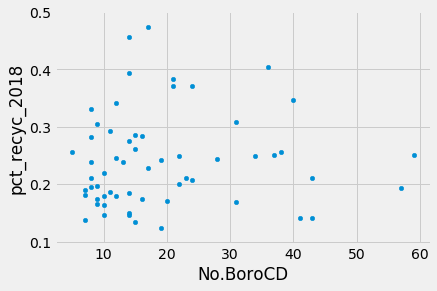

In [81]:
fig=join.plot(kind='scatter',x='No.BoroCD',y='pct_recyc_2018')